In [1]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np 
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Перевести MNIST фото файлы в 4х мерный вектор? (число изображений, высота, ширина, цветовой канал) 
transform = transforms.ToTensor()

In [3]:
# Тренировочные данные
train_data = datasets.MNIST(root='\cnn_data',train=True, 
                            download=True, transform=transform)

In [4]:
# Тестовые данные
test_data = datasets.MNIST(root='\cnn_data',train=False, 
                            download=True, transform=transform)

In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: \cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: \cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [7]:
# Создадим небольшой пакет (батч) изображений... например 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(train_data, batch_size=10, shuffle=False)

In [8]:
# Определим (зададим) нашу сверточную нейронную сеть
# Опишем сверточный слой и что он делает (2 сверточный слой)
# Просто пример, не модель
conv1= nn.Conv2d(1, 6, 3, 1)
conv2 = nn.Conv2d(6, 16, 3, 1)

In [9]:
# Возьмём одну запись/картинку из MNIST
for i, (X_Train, y_train) in enumerate(train_data):
    break

In [10]:
X_Train.shape

torch.Size([1, 28, 28])

In [11]:
x = X_Train.view(1, 1, 28, 28)

In [12]:
# Выполним первый свёрточный слой
x = F.relu(conv1(x)) 
# Вектор, проходя через свёрточный слой, отпарвляется в функцию активации

In [13]:
# 1 единственное изображеие, 6 фильтров которые мы задали
# 26 = 28 (изначальный размер) проходящий фильтром 3, с шагом 1 (без паддинга)
x.shape

torch.Size([1, 6, 26, 26])

In [14]:
# Пройдём через слой Пулинга
x = F.max_pool2d(x, 2, 2) # Размер фильтра 2, шаг 2 

In [15]:
x.shape # 26/2=13 (считать отдельно для каждого размера маски и сдвига, тут так совпало)

torch.Size([1, 6, 13, 13])

In [16]:
# Выполним второй свёрточный слой
x = F.relu(conv2(x)) 

In [17]:
# 1 единственное изображеие, 16 фильтров которые мы задали
# 11 = 13 (изначальный размер после конв1 и пуллинга) 
# проходящий фильтром 3, с шагом 1 (без паддинга)
x.shape

torch.Size([1, 16, 11, 11])

In [18]:
# Пройдём через второй слой Пулинга
x = F.max_pool2d(x, 2, 2) # Размер фильтра 2, шаг 2 

In [19]:
x.shape # 11/2 = 5, округлаяем вниз, мы не можем взять данные с потолка,чтобы округлить вверх 

torch.Size([1, 16, 5, 5])

In [20]:
# Создадим класс Model
class ConvolutionalNetwotk(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 3, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1)
        # Полносвязный слой
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, X):
        # Первая часть свертка + пулинг
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        # Вторая часть свертка + пулинг
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
                         
        # Переписываем вектор в удоборимый формат для выхода
        X = X.view(-1, 16*5*5) # Отрицательный чтобы мы могли варировать batch size
        
        # Полносвязные слои
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)

In [21]:
# Создадим пример использования нашей модели
torch.manual_seed(42)
model = ConvolutionalNetwotk()
model

ConvolutionalNetwotk(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [22]:
# Функция потерь, оптимайзер
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) 
# Чем меньше lr (шаг обучения) тем дольше потребуется времени на тренировку 

In [23]:
import time
start_time = time.time()

# Создадим Переменные чтобы их отслеживать
epochs = 5 
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# Цикл For по каждой эпохе
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0 
    

    # Train
    for b, (X_Train, y_train) in enumerate(train_loader):
        b += 1 # Начнем наши батчи с 1
        y_pred = model(X_Train) # Получим предварительные значения из тренировочного сетта. Не сплюснутый 2д? 
        loss =criterion(y_pred, y_train) # Как плохо все посчиталось? Срваниваем предварительные значения с правильными в Y_train?
        
        predicted = torch.max(y_pred.data, 1)[1] # добавим число правильных предсказаний. Первый индекс
        batch_corr = (predicted == y_train).sum() # Как много мы получили правильных из этого батча (корзины). True =1, False =0, и суммируем
        trn_corr += batch_corr # отслеживаем как проходит тренировка
                
        # Обновим параметры
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Выведем предварительные результаты
        if b%600 == 0:
            print(f'Эпоха: {i} Батч {b} Потери {loss.item()}')
            
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Test
    with torch.no_grad(): # Без градиентта, так как мы не обновляем веса в тестовой дате
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val =model(X_test)
            predicted = torch.max(y_val.data, 1)[1] # Добавляем правильные предикты
            tst_corr += (predicted == y_test).sum() # T=1 F=0 суммируем
            
        loss = criterion(y_val, y_test)
        test_losses.append(loss)
        test_correct.append(tst_corr)
        
        
            
curent_time = time.time()
total_time = curent_time - start_time
print(f'Тренировка заняла:{total_time/60} minutes!')

Эпоха: 0 Батч 600 Потери 0.04045899957418442
Эпоха: 0 Батч 1200 Потери 0.07559648901224136
Эпоха: 0 Батч 1800 Потери 0.3719866871833801
Эпоха: 0 Батч 2400 Потери 0.019858546555042267
Эпоха: 0 Батч 3000 Потери 0.006784805562347174
Эпоха: 0 Батч 3600 Потери 0.0018178500467911363
Эпоха: 0 Батч 4200 Потери 0.46452856063842773
Эпоха: 0 Батч 4800 Потери 0.01664765551686287
Эпоха: 0 Батч 5400 Потери 0.00578678771853447
Эпоха: 0 Батч 6000 Потери 0.04082896560430527
Эпоха: 1 Батч 600 Потери 0.02594258449971676
Эпоха: 1 Батч 1200 Потери 0.08247338235378265
Эпоха: 1 Батч 1800 Потери 0.0029873079620301723
Эпоха: 1 Батч 2400 Потери 0.03080480732023716
Эпоха: 1 Батч 3000 Потери 0.19632332026958466
Эпоха: 1 Батч 3600 Потери 0.00027875968953594565
Эпоха: 1 Батч 4200 Потери 0.0010995141929015517
Эпоха: 1 Батч 4800 Потери 0.0007829269161447883
Эпоха: 1 Батч 5400 Потери 0.0007671666680835187
Эпоха: 1 Батч 6000 Потери 0.007908056490123272
Эпоха: 2 Батч 600 Потери 0.0012740197125822306
Эпоха: 2 Батч 1200 П

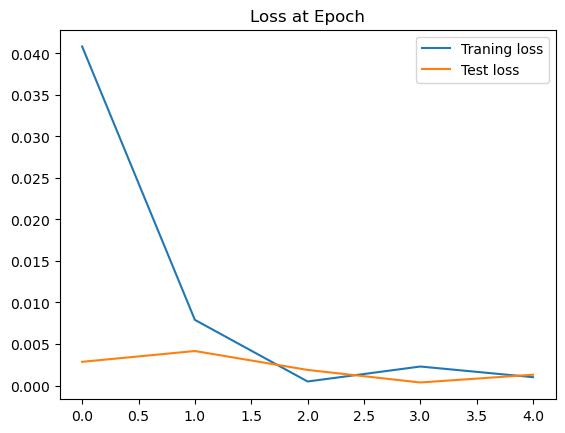

In [27]:
# График потери (loss) от эпох
# train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Traning loss")
plt.plot(test_losses, label="Test loss")
plt.title("Loss at Epoch")
plt.legend()

In [26]:
train_losses

[0.04082896560430527,
 0.007908056490123272,
 0.00048751322901807725,
 0.0022895592264831066,
 0.001005627796985209]

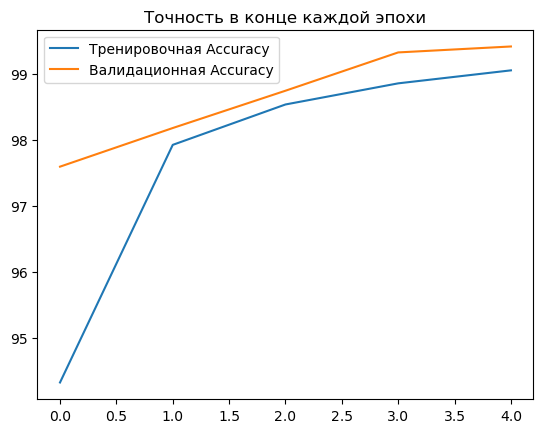

In [28]:
# График сходимости/точности (accuracy) в конце эпох
plt.plot([t/600 for t in train_correct], label = 'Тренировочная Accuracy')
plt.plot([t/600 for t in test_correct], label = 'Валидационная Accuracy')
plt.title('Точность в конце каждой эпохи')
plt.legend()

In [29]:
test_load_everything = DataLoader(test_data, batch_size=10_000, shuffle=False)

In [33]:
with torch.no_grad():
    correct = 0 
    for X_test, y_test in test_load_everything:
        y_val = model(X_test)
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [36]:
# проверим правильность 
correct.item()/len(test_data)

0.9864

In [37]:
# Возьмем изображение
test_data[4143] # Это тензор с изображением, а в конце лейбл (подпись к картинке)

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [38]:
# Возьмем только дату
test_data[4143][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [39]:
# Поменяем размерность?
test_data[4143][0].reshape(28, 28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

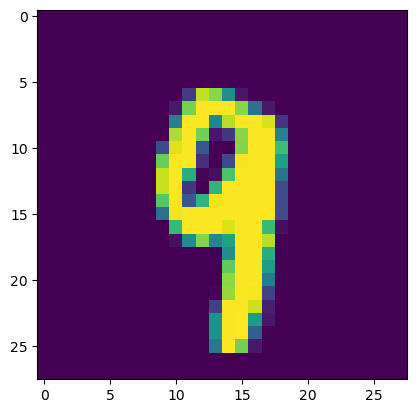

In [40]:
# Продемонстрируем изображение 
plt.imshow(test_data[4143][0].reshape(28, 28))

In [42]:
# прогонем картинку через нашу модель 
model.eval()
with torch.no_grad():
    new_prediction = model(test_data[4143][0].view(1, 1, 28, 28)) 
    # размер бача 1, 1 цветовой канал, 28*28 размер изображения

In [43]:
# Проверим новое предсказани, получим вероятность
new_prediction

tensor([[-2.3612e+01, -1.9567e+01, -2.3012e+01, -1.8031e+01, -1.1151e+01,
         -2.0218e+01, -2.8701e+01, -1.6860e+01, -1.6381e+01, -1.4543e-05]])

In [46]:
new_prediction.argmax()

tensor(9)